
# Synthetic Signal Sweep and Visualization

This notebook uses `src/generate_synthetic_data.py` to generate a synthetic dataset of bearing faults and visualizes the results.

The dataset includes:
- Real 'Normal' baseline signals.
- Synthetic fault signals (Inner, Outer, Ball) superimposed on normal baselines.


In [1]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src is in path
sys.path.append(os.path.abspath('src'))

# Import the generation script
import generate_synthetic_data as gsd

# Configuration for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

In [2]:

# Run the main generation function
print("Generating synthetic data... This may take a moment.")
df = gsd.main()

print(f"Data generation complete. Shape: {df.shape}")
df.head()


Generating synthetic data... This may take a moment.
Starting synthetic data generation...
Total normal segments available in training set: 470
Adding all normal training segments to dataset...
Added 470 normal segments.
Processing RPM: 1730
  Selected 10 baseline segments for synthetic generation.
Processing RPM: 1750
  Selected 10 baseline segments for synthetic generation.
Processing RPM: 1772
  Selected 10 baseline segments for synthetic generation.
Processing RPM: 1797
  Selected 10 baseline segments for synthetic generation.

Generation Complete.
Total records in final DataFrame: 1910

Class Distribution:
fault_type
inner     480
outer     480
ball      480
Normal    470
Name: count, dtype: int64

Sample Data:
    rpm fault_type  diameter  k_val  \
0  1730     Normal       NaN    NaN   
1  1730     Normal       NaN    NaN   
2  1730     Normal       NaN    NaN   
3  1730     Normal       NaN    NaN   
4  1730     Normal       NaN    NaN   

                                       

,rpm,fault_type,diameter,k_val,signal
0,1730,Normal,NaN,NaN,"[0.014603076923076923, 0.05444861538461539, 0...."
1,1730,Normal,NaN,NaN,"[-0.014603076923076923, 0.01668923076923077, 0..."
2,1730,Normal,NaN,NaN,"[0.05799507692307692, 0.08740984615384616, 0.0..."
3,1730,Normal,NaN,NaN,"[-0.007510153846153846, -0.06967753846153846, ..."
4,1730,Normal,NaN,NaN,"[0.08052553846153847, 0.07259815384615384, 0.0..."


## 1. Class Distribution

C:\Users\Cliente\AppData\Local\Temp\ipykernel_5196\2274581862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='fault_type', palette='viridis')


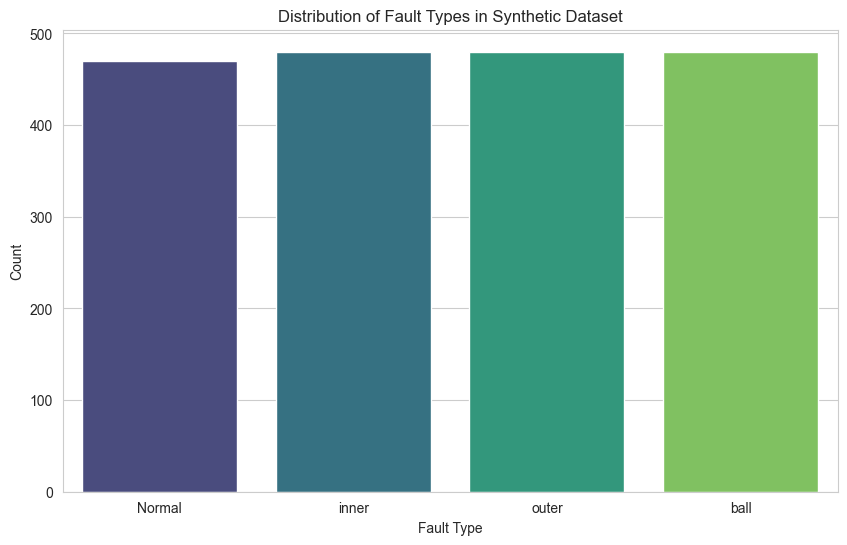

In [3]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='fault_type', palette='viridis')
plt.title('Distribution of Fault Types in Synthetic Dataset')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.show()



## 2. Signal Visualization

We will plot a random sample from each class (Normal, Inner, Outer, Ball) to visually verify the signals.


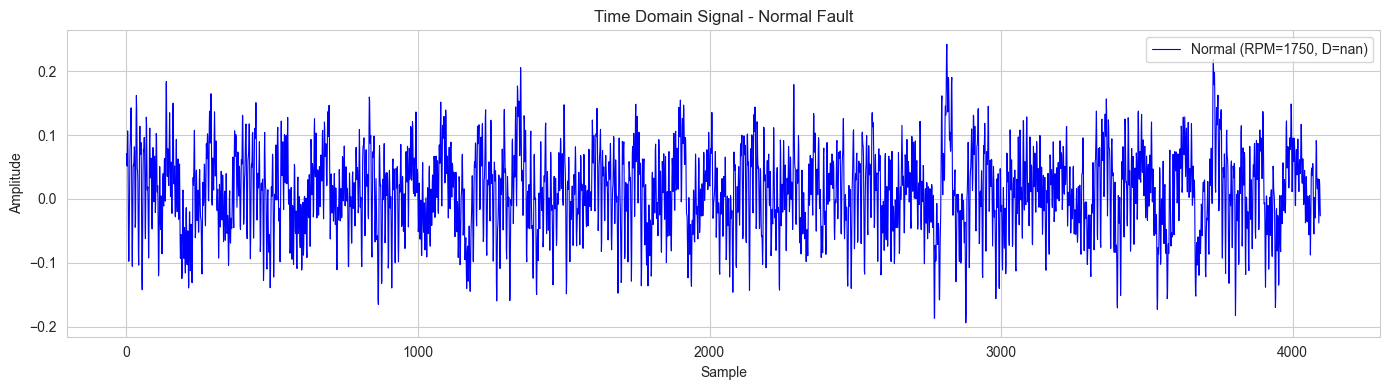

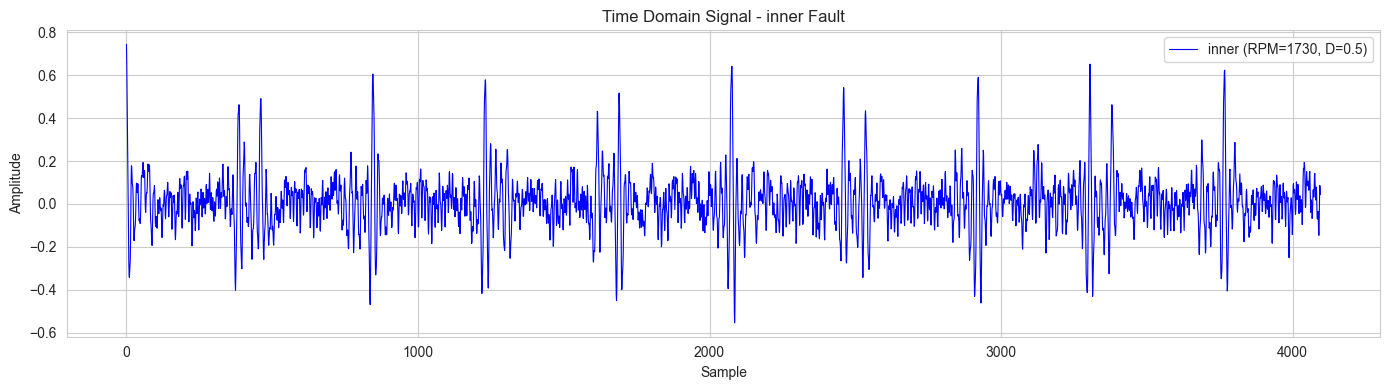

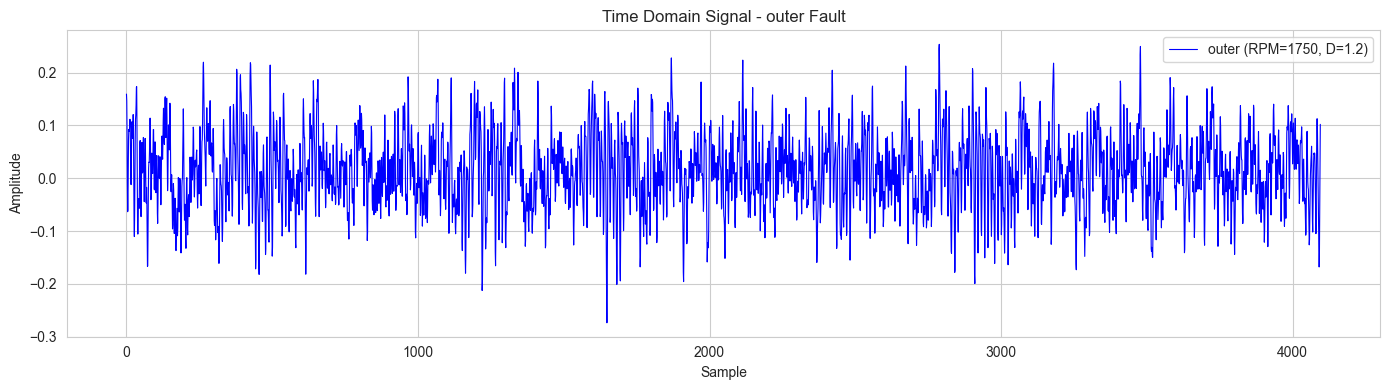

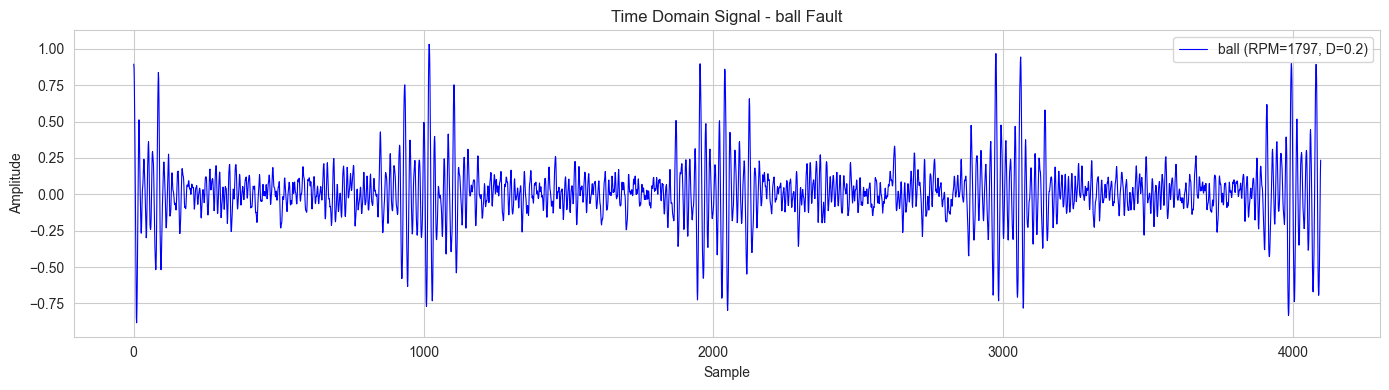

In [4]:

def plot_signals_by_class(dataframe, num_samples=1):
    fault_types = dataframe['fault_type'].unique()
    
    for f_type in fault_types:
        subset = dataframe[dataframe['fault_type'] == f_type]
        if subset.empty:
            continue
            
        samples = subset.sample(min(num_samples, len(subset)))
        
        for idx, row in samples.iterrows():
            signal = row['signal']
            rpm = row['rpm']
            diam = row['diameter']
            
            plt.figure(figsize=(14, 4))
            plt.plot(signal, label=f'{f_type} (RPM={rpm}, D={diam})', color='blue', linewidth=0.8)
            plt.title(f'Time Domain Signal - {f_type} Fault')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

# Plot 1 random signal from each class
plot_signals_by_class(df, num_samples=1)


## 3. Frequency Domain Comparison (FFT)

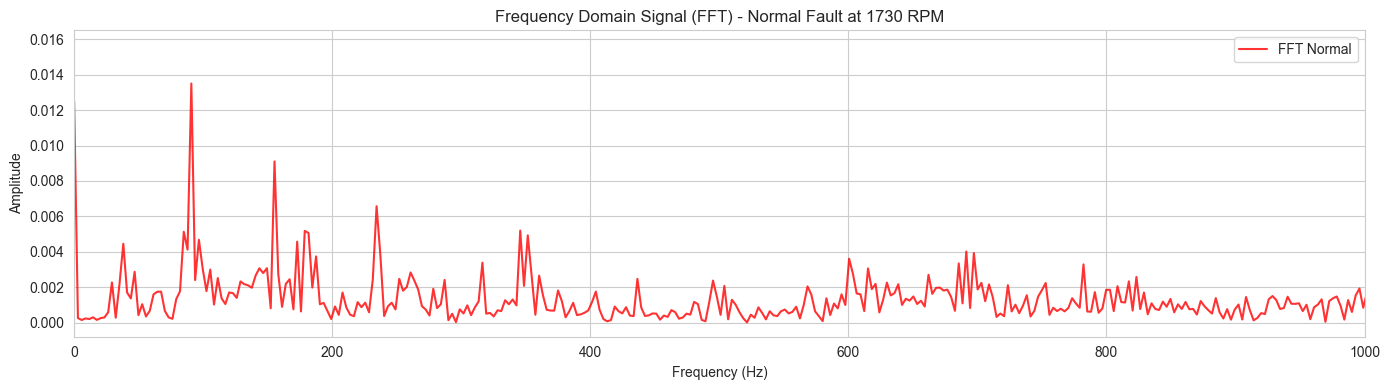

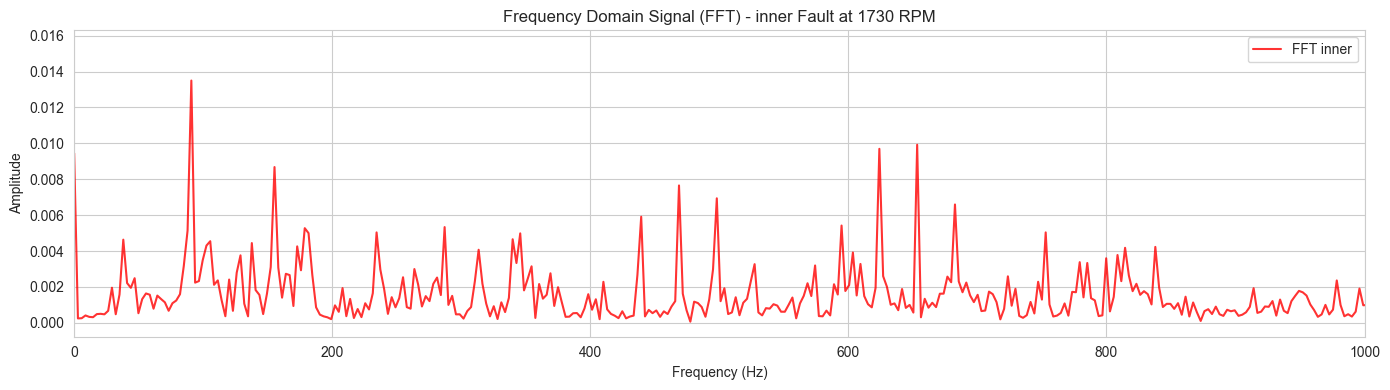

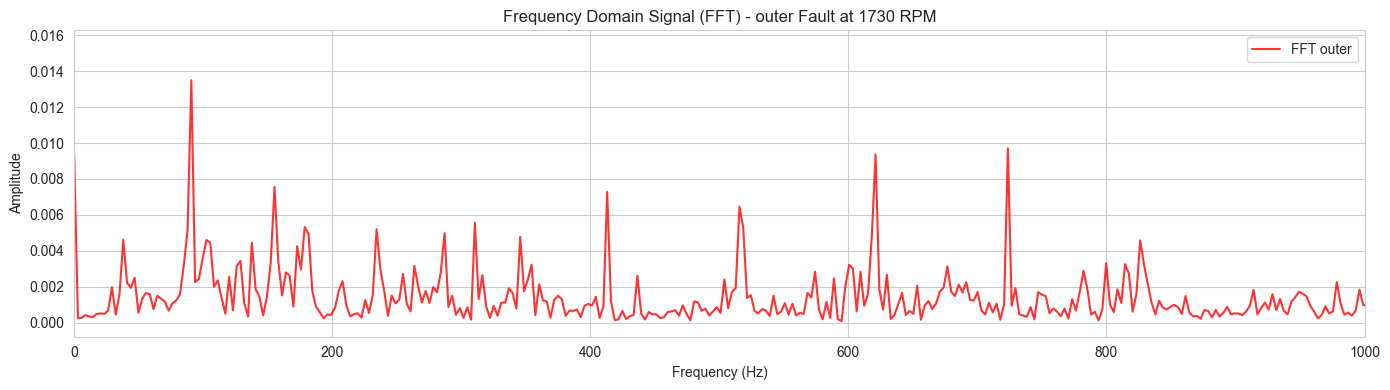

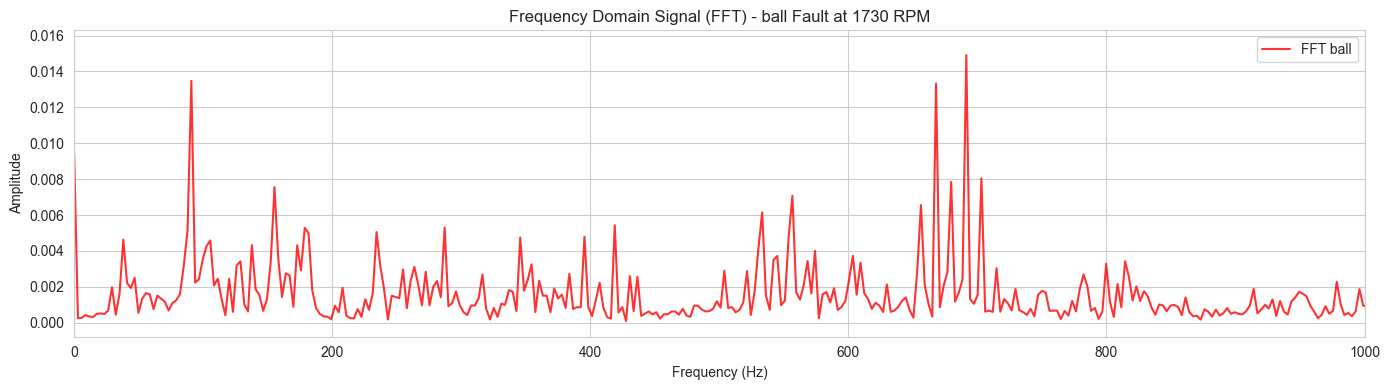

In [6]:

def plot_fft_by_class(dataframe):
    # Select one example per fault type for a target RPM and plot FFT separately
    target_rpm = 1730
    subset = dataframe[dataframe['rpm'] == target_rpm]
    
    if subset.empty:
        print(f"No data for RPM {target_rpm}")
        return

    fault_types = subset['fault_type'].unique()
    
    for f_type in fault_types:
        class_subset = subset[subset['fault_type'] == f_type]
        if class_subset.empty:
            continue
            
        # Take first sample
        signal = class_subset.iloc[0]['signal']
        
        # FFT
        n = len(signal)
        fs = 12000
        freq = np.fft.rfftfreq(n, d=1/fs)
        fft_val = np.abs(np.fft.rfft(signal)) / n
        
        plt.figure(figsize=(14, 4))
        plt.plot(freq, fft_val, label=f'FFT {f_type}', color='red', alpha=0.8)
        plt.title(f'Frequency Domain Signal (FFT) - {f_type} Fault at {target_rpm} RPM')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
        plt.xlim(0, 1000) # Zoom in on lower frequencies where bearing faults usually are
        plt.tight_layout()
        plt.show()

plot_fft_by_class(df)
